In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import numpy as np
from itertools import tee
from gui.user_code import pairwise_randomised_significance, get_data_for_signif_test
from gui.output_utils import get_cv_fold_count, get_cv_scores_many_experiment
from gui.constants import CLASSIFIER

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# Does the classification evaluation framework work?
What is the effect of adding uniform random noise to vectors? Can our experiments tell between a set of vectors and a corrupted version of the same vectors? To find out, add uniform random noise from $-n$ to $n$ (x axis) to all non-zero entries in a set of `word2vec` embeddings.
     

experiments are [97, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
id 97 noise 0.00, acc 0.46, macrof1 0.42
id 74 noise 0.20, acc 0.46, macrof1 0.42
id 75 noise 0.40, acc 0.49, macrof1 0.44
id 76 noise 0.60, acc 0.46, macrof1 0.42
id 77 noise 0.80, acc 0.39, macrof1 0.35
id 78 noise 1.00, acc 0.35, macrof1 0.30
id 79 noise 1.20, acc 0.31, macrof1 0.27
id 80 noise 1.40, acc 0.29, macrof1 0.25
id 81 noise 1.60, acc 0.27, macrof1 0.24
id 82 noise 1.80, acc 0.26, macrof1 0.23
id 83 noise 2.00, acc 0.24, macrof1 0.21
noise has 5500 values
folds has 5500 values
Accuracy has 5500 values


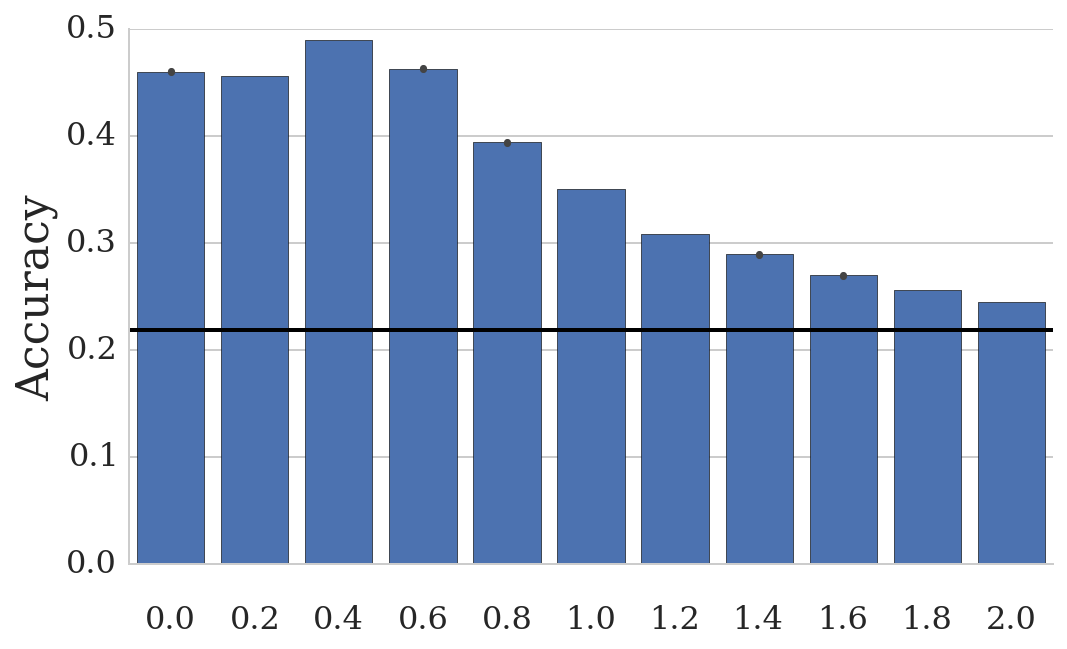

In [2]:
d = {'expansions__vectors__unlabelled_percentage': 100,
     'labelled': 'amazon_grouped-tagged',
     'expansions__vectors__dimensionality': 100,
     'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
     'expansions__vectors__composer': 'Add',
     'expansions__vectors__rep': 0, 
     'expansions__allow_overlap': False,
     'expansions__k': 3,
     'expansions__vectors__unlabelled': 'wiki',
     'expansions__vectors__algorithm': 'word2vec',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN'}
experiments = Experiment.objects.filter(**d).order_by('expansions__noise')
e = [x.id for x in experiments if x.expansions.entries_of is None]
print('experiments are', e)

for eid in e:
    print('id %d noise %2.2f, acc %2.2f, macrof1 %2.2f'%(eid,
                                          Experiment.objects.get(id=eid).expansions.noise,
                                          Results.objects.get(id=eid, classifier=CLASSIFIER).accuracy_mean,
                                          Results.objects.get(id=eid, classifier=CLASSIFIER).macrof1_mean))
    
# cv_folds = get_cv_fold_count(e)
# scores, folds = get_cv_scores_many_experiment(e)
df = dataframe_from_exp_ids(e, {'noise':'expansions__noise'})
df['tidy_noise'] = ['%1.1f'%float(x) for x in df.noise]
ax = sns.factorplot(x='tidy_noise', y='Accuracy', data=df, kind='bar', aspect=1.5);
ax.set_xlabels('')

# random baseline for comparison
plt.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-noise-gigaword-add.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)